# Preprocessing of dMRI data

This preprocessing is based on Wiktor's work with dMRI data. A specific file is taken as an example.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import nibabel as nib
from os import listdir
from os.path import isfile, join
from scipy import signal
import sys

In [2]:
# current path
cur_path = os.getcwd()

In [3]:
path_output = "/".join(cur_path.split("/")[:-1])+ "/data/"

In [6]:
# file name and path
file = "BB_003_3T_cmrr_mbep2d_diff_0pt2_1_task_18s_off_12s_on_20200710180104_8"
raw_file_name = "/".join(cur_path.split("/")[:-2]) + "/analyses_output/"+str(file)+"/dfMRI_raw.nii.gz"
# loading nifti object/header
raw_data_ = nib.load(raw_file_name)
header  = raw_data_.header
raw_data = raw_data_.get_fdata()

In [3]:
header.get_xyzt_units()

('mm', 'sec')

In [4]:
raw_data.shape

(116, 116, 14, 600)

In [34]:
def print_volume(data, time = 15):
    # print all slices wrt z axis after defining a random time 
    slices = []
    for s in range(data.shape[2]):
        z_slice = data[:, :, s,time]
        slices.append(z_slice)

    nrows = 2
    ncols=int(len(slices)/nrows)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10, 10))
    ii = 0
    for i, slice in enumerate(slices):
        row = int(ii/ncols)
        col = ii%ncols
        ax[row][col].imshow(slice.T, cmap="gray", origin="lower")
        ii = ii + 1

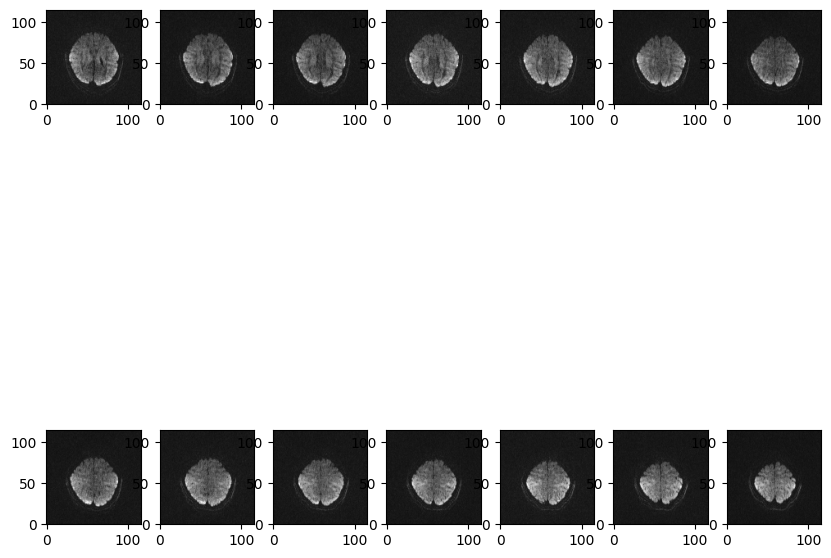

In [6]:
print_volume(raw_data)

# Getting rid of the first volumes

1st volume for some scans has to be removed as sometimes it has another b-value than the remaining volumes (we wanted to cover different b-values - calibration issues)


In [7]:
No_dummies_out = 0

In [8]:
dfMRI_raw  = raw_data[:,:,:,No_dummies_out:]

In [9]:
No_volumes = raw_data.shape[3]

In [10]:
dfMRI_raw.shape

(116, 116, 14, 600)

# Identifying volume outliers and removing them

In [11]:
if "diff" in file_name:
    # if it is diffusion data
    make_adc = True
else :
    # BOLD 
    make_adc = False

In [12]:
# compress into 2D
dfMRI_raw_2D = dfMRI_raw.reshape(dfMRI_raw.shape[0]*dfMRI_raw.shape[1]*dfMRI_raw.shape[2], dfMRI_raw.shape[3])

In [13]:
dfMRI_raw_2D.shape

(188384, 600)

In [14]:
# mean over the volume
mean_dfMRI_raw_2D = np.mean(dfMRI_raw_2D, axis = 0)

In [15]:
mean_dfMRI_raw_2D.shape

(600,)

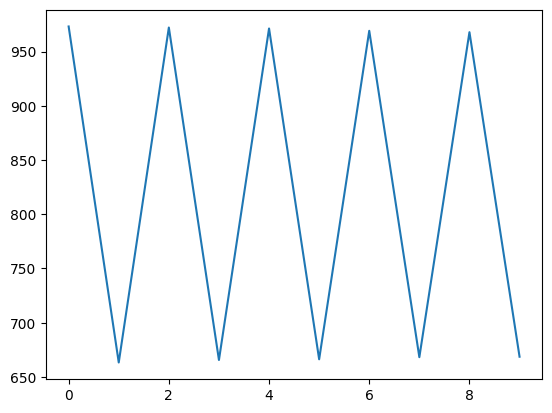

In [16]:
plt.plot(mean_dfMRI_raw_2D[:10])

This shows that there are 2 different b values in the data that need to be separated

In [17]:
if make_adc:
    # separate b values
    b1_times = np.arange(0, len(mean_dfMRI_raw_2D),2)
    b2_times = np.arange(1, len(mean_dfMRI_raw_2D),2)
    b1_mean_dfMRI = mean_dfMRI_raw_2D[b1_times]
    b2_mean_dfMRI = mean_dfMRI_raw_2D[b2_times]
    
    # detrend for movement correction
    b1_mean_dfMRI_det= signal.detrend(b1_mean_dfMRI) - np.mean(signal.detrend(b1_mean_dfMRI)) + np.mean(b1_mean_dfMRI);
    b2_mean_dfMRI_det= signal.detrend(b2_mean_dfMRI) - np.mean(signal.detrend(b2_mean_dfMRI)) + np.mean(b2_mean_dfMRI);
   

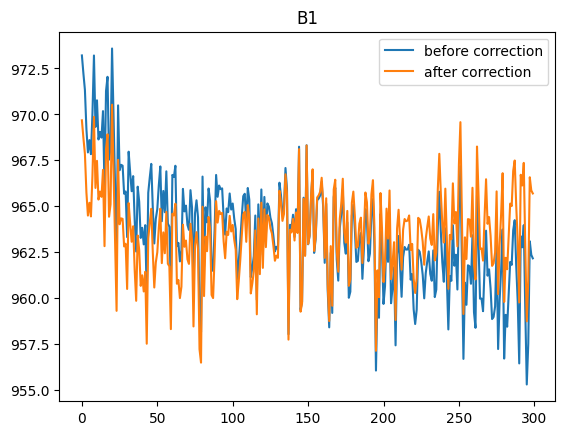

In [18]:
plt.plot(b1_mean_dfMRI, label = "before correction")
plt.plot(b1_mean_dfMRI_det, label = "after correction")
plt.title("B1")
plt.legend()

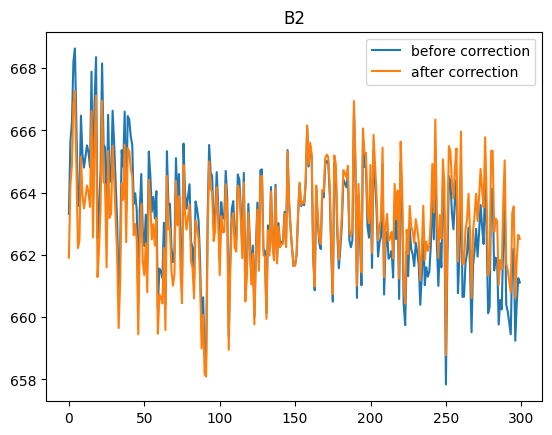

In [19]:
plt.plot(b2_mean_dfMRI, label = "before correction")
plt.plot(b2_mean_dfMRI_det, label = "after correction")
plt.title("B2")
plt.legend()

In [20]:
vol_outliers_thr = 0.01

In [21]:
# Discard outliers (if any)
b1_mean_dfMRI_outliers = b1_mean_dfMRI_det.copy()
med = np.median(b1_mean_dfMRI_outliers)
b1_vol_outliers = np.where(abs(b1_mean_dfMRI_outliers- med) > vol_outliers_thr*med)
#b1_mean_dfMRI_wo_outliers = b1_mean_dfMRI_outliers.copy()
#b1_mean_dfMRI_wo_outliers[b1_vol_outliers] = np.nan

b2_mean_dfMRI_outliers = b2_mean_dfMRI_det.copy()
med = np.median(b2_mean_dfMRI_outliers)
b2_vol_outliers = np.where(abs(b2_mean_dfMRI_outliers- med) > vol_outliers_thr*med)
#b2_mean_dfMRI_wo_outliers = b2_mean_dfMRI_outliers.copy()
#b2_mean_dfMRI_wo_outliers[b2_vol_outliers] = np.nan

In [22]:
del  b1_mean_dfMRI, b2_mean_dfMRI, b1_mean_dfMRI_det, b2_mean_dfMRI_det

In [23]:
dfmri = raw_data
for i in b1_times[b1_vol_outliers]:
    dfmri[:,:,:,i] = np.nan
for i in b2_times[b2_vol_outliers]:
    dfmri[:,:,:,i] = np.nan


In [24]:
del b1_vol_outliers, b2_vol_outliers

In [25]:
img = nib.Nifti1Image(dfmri, np.eye(4))

In [26]:
dfmri.shape

(116, 116, 14, 600)

In [27]:
nib.save(img, 'test_part1.nii.gz')  

# PCA denoising

Open terminal in the right folder and run :

dwidenoise test_part1.nii.gz test_part2.nii.gz -noise noise.nii.gz -extent 9 -force

In [4]:
file_name = cur_path + "/test_part2.nii.gz"
# loading nifti object
pca_dfmri = nib.load(file_name)
pca_dfmri = pca_dfmri.get_fdata()

In [5]:
file_name = cur_path + "/noise.nii.gz"
# loading nifti object
noise = nib.load(file_name)
noise = noise.get_fdata()

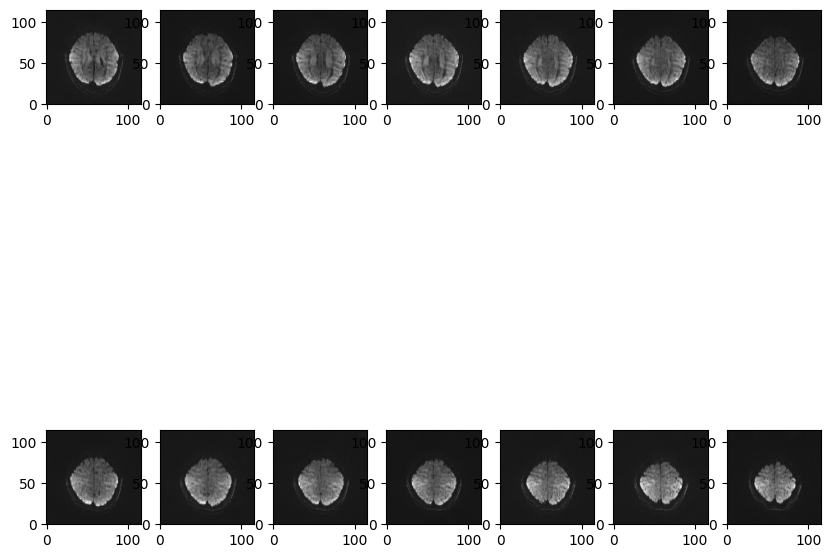

In [6]:
print_volume(pca_dfmri)

In [7]:
noise.shape

(116, 116, 14)

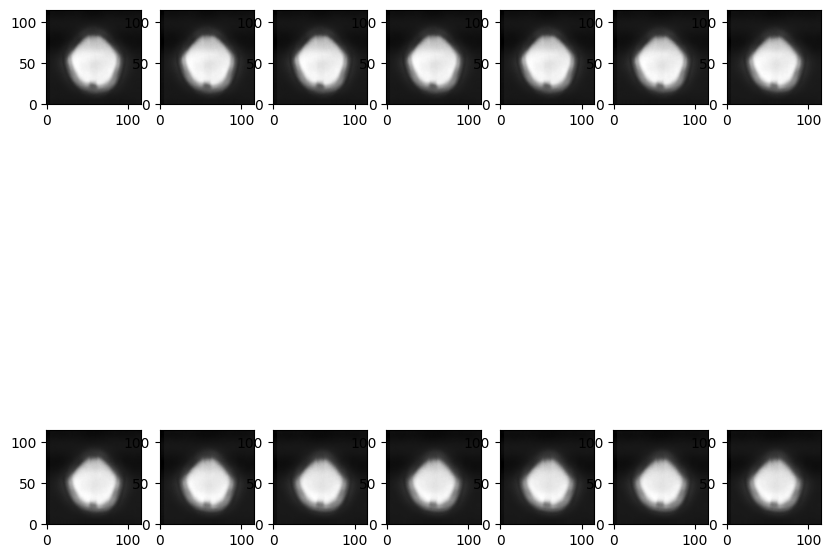

In [11]:
# print all slices wrt z axis 
nrows = 2
ncols=int(noise.shape[2]/nrows)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10, 10))
ii = 0
for i in range(noise.shape[2]):
    slice = noise[:,:,i]
    row = int(ii/ncols)
    col = ii%ncols
    ax[row][col].imshow(slice.T, cmap="gray", origin="lower")
    ii = ii + 1

# Gibbs unringing

## Option 1 

Run in terminal :
mrdegibbs test_part2.nii.gz test_part3.nii.gz

In [16]:
file_name = cur_path + "/test_part3.nii.gz"
# loading nifti object
gibbs_dfmri = nib.load(file_name)
gibbs_dfmri = gibbs_dfmri.get_fdata()

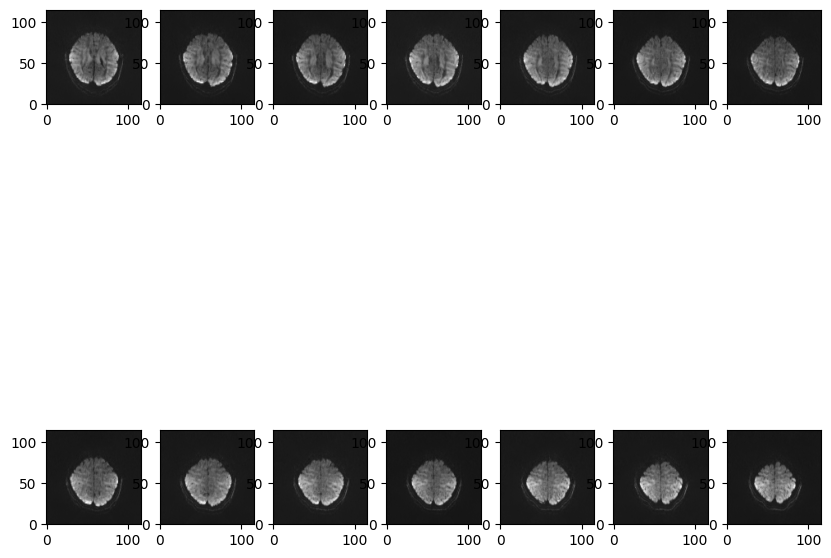

In [17]:
print_volume(gibbs_dfmri)

## Option 2

In [4]:
def flushprint(text):
    sys.stdout.write(f'{text} \r')
    sys.stdout.flush()

In [5]:
def cpheader(from_im, to_im, newimg=False, cpbytes=False):
    """Copy the header by replacing the data of to_im to from_im.
        By default, tries overwrites to_im, newimg='path' to save a new img"""
    # ToDo: test copy bytes
    if not cpbytes:
        to_im_name = to_im
        from_im = nib.load(from_im)
        to_im = nib.load(to_im)
        new_img = to_im.__class__(to_im.dataobj[:], from_im.affine, from_im.header)
        if newimg:
            new_img.to_filename(newimg)
        else:
            out = to_im_name
            os.rename(out, out.replace('.nii', '__TMP4HDRCOPY__.nii'))
            new_img.to_filename(out)
            os.remove(out.replace('.nii', '__TMP4HDRCOPY__.nii'))
    else:
        with open(from_im, "rb") as donor:
            if newimg:
                with open(newimg, "wb") as receiver:
                    receiver.seek(0)  # set bytes offset at 0
                    receiver.write(donor.read()[0:349])  # First 348 bytes are the header
                    receiver.seek(349)  # set bytes offset at 349
                    with open(to_im, "rb") as datadonor:
                        receiver.write(datadonor.read()[349:])  # write data from the 349 byte
            else:
                with open(to_im, "wb") as receiver:
                    receiver.seek(0)  # set bytes offset at 0
                    receiver.write(donor.read()[0:349])  # First 348 bytes are the header

In [ ]:
def split_degibbs(denoisedimage, dictlist, MATLABEXEC='', newimg='/split_degibbs_dwi.nii.gz', dim=2,
                  partialfourier=0.75, software='reisert', delete_subparts=True):
    # Split the denoised image into 5
    start = time.time()
    img = nib.load(denoisedimage)
    # Initialize the list
    split_degibbs_dictlist = []
    start_bid = 0
    for img_nb in range(len(dictlist)):
        # Split the dwi nifti from files_dic according to the length of the 'img_nb'th bval vector
        bval_length = len(np.loadtxt(dictlist[img_nb]['bval'], dtype=int))
        newnifti = nib.Nifti1Image(img.get_fdata()[..., start_bid:(start_bid + bval_length)], affine=img.affine,
                                   header=img.header)
        nib.save(newnifti, denoisedimage.replace('.nii.gz', f'_subpart-{img_nb}.nii.gz'))
        start_bid += bval_length
        # Create a new dictionary for the splitted part
        # Copy the content of bvals, bvec and json from each dictionary in diclist
        files_dic_spec = dictlist[img_nb].copy()
        files_dic_spec['dwi'] = denoisedimage.replace('.nii.gz', f'_subpart-{img_nb}.nii.gz')
        # Apply degibbs on each splitted part
        split_degibbs_dic = degibbs(files_dic_spec, MATLABEXEC=MATLABEXEC,
                                    newimg=newimg.replace('.nii.gz', f'_subpart-{img_nb}.nii.gz'),
                                    dim=dim, partialfourier=partialfourier, software=software)
        # Append the result to the list of processed parts
        split_degibbs_dictlist.append(split_degibbs_dic)
        # Remove the denoised subpart
        if delete_subparts:
            os.remove(denoisedimage.replace('.nii.gz', f'_subpart-{img_nb}.nii.gz'))
    # Merge results
    file = merge_degibbs(split_degibbs_dictlist, newimage=newimg, delete_subparts=delete_subparts)

    print("Split, degibbs & merge finished !")
    end = time.time()
    print(f"In :{int((end - start) // 3600)}h, {int((end - start) % 3600 // 60)}min and {int((end - start) % 60)}s.")

    return file


def merge_degibbs(files, newimage='/split_degibbs_dwi.nii.gz', delete_subparts=True):
    baseimg = nib.load(files)
    aff, hdr = baseimg.affine, baseimg.header
    basedata = baseimg.get_fdata()
    # Remove old subpart file
    if delete_subparts:
        os.remove(files[0])

    for id, dic in enumerate(dictlist[1:], 1):
        # Merge dwi 4th dim (axis = 3)
        basedata = np.concatenate([basedata, nib.load(dic['dwi']).get_fdata()], axis=3)

        # Remove old subpart file
        if delete_subparts:
            os.remove(dictlist[id]['dwi'])

    files_dic = {'bval': newimage.replace('_desc-splitted_degibbs_dwi.nii.gz', '_dwi.bval'),
                 'bvec': newimage.replace('_desc-splitted_degibbs_dwi.nii.gz', '_dwi.bvec'),
                 'json': [d['json'] for d in dictlist],
                 'dwi': newimage,
                 'tdval': newimage.replace('_desc-splitted_degibbs_dwi.nii.gz', '_dwi.tdval')}

    newimg = nib.Nifti1Image(basedata, affine=aff, header=hdr)
    nib.save(newimg, newimage)


In [101]:
# step 3 : de-Gibbs ringing functions
# thanks to Quentin and Tommaso !
def degibbs(in_dwi, newimg='test_part3.nii.gz', software='reisert', dim=3, partialfourier=0.75, MATLABEXEC=''):
    """
    :param files_dic: dictionary of current file to be processed
    :param newimg: output file name
    :param dim: dim
    :param partialfourier: partial fourier values
    :param MATLABEXEC: matlab executable path
    :return: files dictionary with updated degibbs file
    """

    origin = os.getcwd()  # get .py file position in the pc
    origin = "/".join(cur_path.split("/")[:-1]) 

    if software == 'rpg':
        in_dwi_nii = gzip(in_dwi, gz=False)
        print(f'Running rpg degibbs in: {origin}')
        a = '"'  # apostrophe
        command = [f"{MATLABEXEC}",
                   f"-sd {os.getcwd()} -batch {a}",
                   f"addpath(genpath('{origin}/lib/rpgdegibbs/lib'));"
                   f"addpath(genpath('{origin}/lib/NIFTI'));"
                   f"root='{os.path.dirname(in_dwi_nii)}';"
                   f"warning('off','all');"
                   f"rpg = rpgdegibbs();"
                   f"P_pf = load_untouch_nii('{in_dwi_nii}');"
                   f"dim = {dim};"
                   f"pf = {partialfourier};"
                   f"P_pf_dg = rpg.degibbs(abs(double(P_pf.img)), dim, pf);"
                   f"P_pf.img = P_pf_dg;"
                   f"disp('Gibbs unringing');"
                   f"save_untouch_nii(P_pf, '{newimg.replace('.gz', '')}');"
                   f"quit force;"
                   f"{a}"]
        sp.run(command)
        newimage = gzip(newimg.replace('.gz', ''), gz=True)

    elif software == 'reisert':
        # from:  https://bitbucket.org/reisert/unring/src/master/matlab/unring.m
        print(f'Running reisert unring in: {origin}')
        dwi = nib.load(in_dwi)
        tmp_names = list()

        for v in range(dwi.shape[-1]):
            flushprint(f'{100 / dwi.shape[-1] * v}')
            newnifti = nib.Nifti1Image(dwi.get_fdata()[:,:, :, v], affine=dwi.affine, header=dwi.header)
            tmpname = newimg.replace('.nii.gz', f'_TMP{v}.nii.gz')
            nib.save(newnifti, tmpname)
            os.system(
                f'{origin}/lib/reisert_unring/fsl/unring.a64 {tmpname} {tmpname} -d {dim} >> {newimg.replace(".nii.gz", ".unring.log")}')
            os.remove(newimg.replace(".nii.gz", ".unring.log"))
            tmp_names.append(tmpname)
  

        os.system(f'fslmerge -t {newimg} {" ".join(tmp_names)}')
        cpheader(in_dwi, newimg)
        if os.path.isfile(newimg):
            [os.remove(tmp) for tmp in tmp_names]
    else:
        raise ValueError("software could be only 'reisert'(c) or 'rpg'(matlab) ")

    if not os.path.isfile(newimg):
        raise ValueError('Degibbs Failed!')


In [102]:
degibbs(path_output+"test_part2.nii.gz", newimg=path_output+'test_part3.nii.gz')

Running reisert unring in: /home/localadmin/Documents/Dfmri_data/preprocessing


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.
.


# SNR

In [4]:
def signaltonoise(in_dwi, axis=0, ddof=0):
    dwi = nib.load(in_dwi)
    snr = []
    for t in range(dwi.shape[-1]):
        snr_v = []
        for v in range(dwi.shape[-2]):
            a = dwi.get_fdata()[..., v, t]
            a = np.asanyarray(a)
            m = a.mean(axis)
            sd = a.std(axis=axis, ddof=ddof)
            snr_v.append(list(np.where(sd == 0, 0, m/sd)))
        snr.append(np.mean(snr_v, axis = 0))
    return np.mean(snr, axis = 0)

In [7]:
snr_3 = signaltonoise(path_output+"test_part3.nii.gz")
snr_2 = signaltonoise(path_output+"test_part2.nii.gz")
snr_1 = signaltonoise(path_output+"test_part1.nii.gz")
raw = signaltonoise(raw_file_name)

(1.2, 1.5)

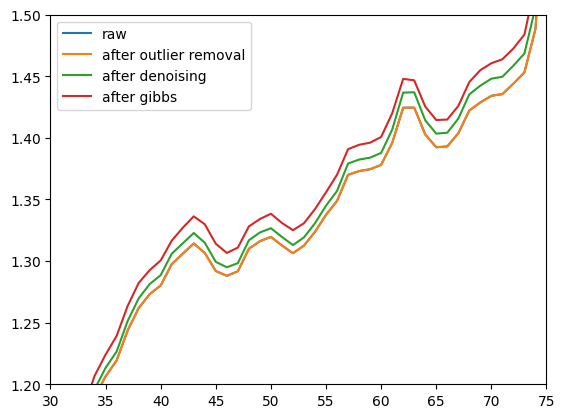

In [29]:
plt.plot(raw, label = "raw")
plt.plot(snr_1, label = "after outlier removal")
plt.plot(snr_2, label = "after denoising")
plt.plot(snr_3, label = "after gibbs")
plt.legend()
plt.xlim([30,75])
plt.ylim([1.2,1.5])

In [17]:
snr_3_ = signaltonoise(path_output+"test_part3.nii.gz", axis=1)
snr_2_ = signaltonoise(path_output+"test_part2.nii.gz", axis=1)
snr_1_ = signaltonoise(path_output+"test_part1.nii.gz", axis=1)
raw_ = signaltonoise(raw_file_name, axis=1)

/tmp/ipykernel_46632/4245035100.py:11: RuntimeWarning: invalid value encountered in divide
  snr_v.append(list(np.where(sd == 0, 0, m/sd)))


(1.0, 1.8)

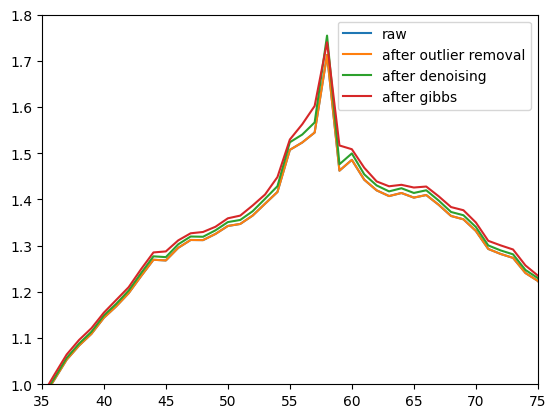

In [27]:
plt.plot(raw_, label = "raw")
plt.plot(snr_1_, label = "after outlier removal")
plt.plot(snr_2_, label = "after denoising")
plt.plot(snr_3_, label = "after gibbs")
plt.legend()
plt.xlim([35,75])
plt.ylim([1,1.8])

# Before vs after Gibbs

In [30]:
bef_gibbs = nib.load(path_output+"test_part2.nii.gz")
after_gibbs = nib.load(path_output+"test_part3.nii.gz")

In [33]:
diff = bef_gibbs.get_fdata() - after_gibbs.get_fdata()

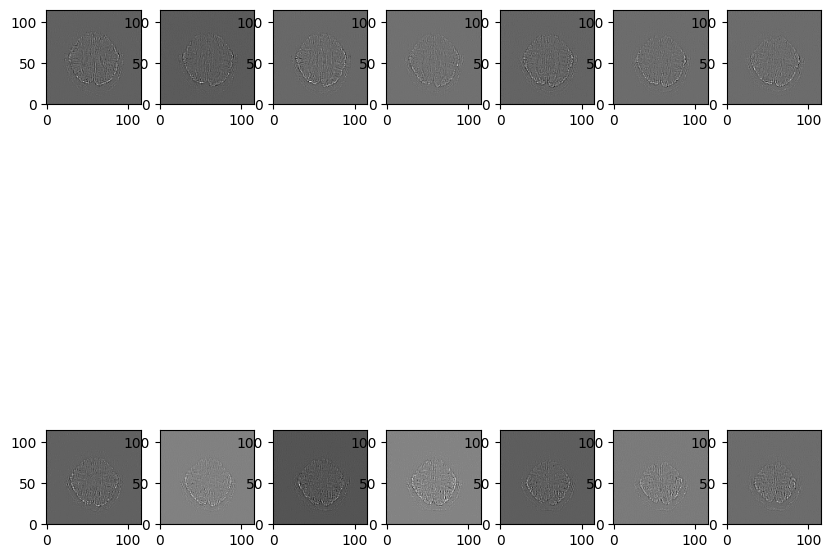

In [35]:
print_volume(diff)

In [37]:
diff = nib.Nifti1Image(diff, np.eye(4))
nib.save(diff,path_output+ "diff.nii.gz")